# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *R*

**Names:**

* *Raphael Barman*
* *Thierry Bossy*
* *Raphael Strebel*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [5]:
import networkx as nx
import random as rand
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def randomWalk(graph, nb_visits):
    
    nb_nodes = len(graph.nodes())
    
    # Array keeping track of number of times each node is visited (initilized to 0)
    total_visits = [0]*nb_nodes

    # Choose source node randomly
    source = graph.nodes()[rand.randint(0, nb_nodes-1)]
    print("source: ", source)
    total_visits[int(source)] = 1 
    current_node = source
    
    for i in range(0, nb_visits-1):
        # Choose next node randomly from the list of neighbors of the current node
        nb_neighbors = len(graph.neighbors(current_node))
        # Break if we are in an absorbing node
        if(nb_neighbors == 0):
            break
        next_node = graph.neighbors(current_node)[rand.randint(0, nb_neighbors-1)]
        total_visits[int(next_node)] = total_visits[int(next_node)] + 1
        current_node = next_node 
    return total_visits


In [7]:
# On components graph
components_graph = nx.DiGraph()
components_graph = nx.read_adjlist('../data/components.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 10000

print(randomWalk(components_graph, nb_visits))

source:  7
[0, 0, 0, 0, 2865, 1404, 2865, 2866]


In [8]:
# On absorbing graph 
absorbing_graph = nx.DiGraph()
absorbing_graph = nx.read_adjlist('../data/absorbing.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 10000

print(randomWalk(absorbing_graph, nb_visits))

source:  0
[1, 1, 0, 0, 1]


Components graph:
In the components graph, there are two connected components, the first one being (0,1,2,3) and the second one being (4,5,6,7). Since we choose the source randomly, we either start (and stay) in the first component or in the second. When we draw the graph we get:

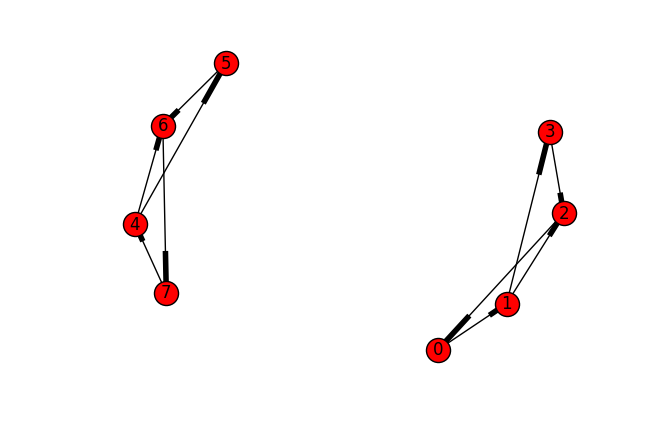

In [9]:
nx.draw(components_graph, with_labels=True)

And we see that when we are in the first component we always go trough the nodes 0, 1 and 2 but we only go trough 3 with 0.5 probability, which explains the results we got. Similarly, in the second component we pass through nodes 5, 4 and 7 at every turn but we go through node 5 only every second turn.

Absorbing graph:
When drawing the absorbing graph we get the following picture:

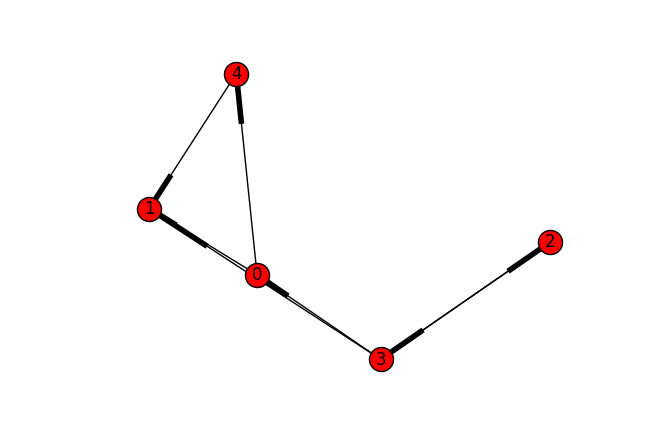

In [10]:
nx.draw(absorbing_graph, with_labels=True)

In the absorbing graph we notice that node 1 is absorbing, so we stay in node 1 once we came accross it. The only way we can avoid node 1 is by going back and forth from node 2 to node 3 (one of them has to be the source vertex), but when in node 3, we go back to node 2 with probability 1/3, and any other node we travel to ends up going to node 1. This explains why we have so few iterations even when trying to visit a large number of nodes.

#### Exercise 2.13

In [11]:
def pageRank(graph, nb_visits):
    nb_nodes = len(graph.nodes())
    
    # Array keeping track of number of times each node is visited (initilized to 0)
    total_visits = [0]*nb_nodes

    # Choose source node randomly
    source = graph.nodes()[rand.randint(0, nb_nodes-1)]
        
    total_visits[int(source)] = 1 
    current_node = source
    
    for i in range(0, nb_visits-1):
        damping_factor = rand.uniform(0,1)
        # Choose next node randomly with probability 0.15
        if(damping_factor <= 0.15):
            next_node = graph.nodes()[rand.randint(0, nb_nodes-1)]
        else:
            # Choose next node randomly from the list of neighbors of the current node
            nb_neighbors = len(graph.neighbors(current_node))
            # Choose new random node if we are in an absorbing node
            if(nb_neighbors == 0):
                next_node = graph.nodes()[rand.randint(0, nb_nodes-1)]
            else:
                next_node = graph.neighbors(current_node)[rand.randint(0, nb_neighbors-1)]
        total_visits[int(next_node)] = total_visits[int(next_node)] + 1
        current_node = next_node 
    ratio = [x / nb_visits for x in total_visits]
    return ratio

In [12]:
# On components graph
components_graph = nx.DiGraph()
components_graph = nx.read_adjlist('../data/components.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 10000

print(pageRank(components_graph, nb_visits))

[0.1382, 0.1361, 0.141, 0.0756, 0.1429, 0.0746, 0.1465, 0.1451]


In [13]:
# On absorbing graph 
absorbing_graph = nx.DiGraph()
absorbing_graph = nx.read_adjlist('../data/absorbing.graph', create_using=nx.DiGraph())

# Arbitrary number of visits
nb_visits = 10000

print(pageRank(absorbing_graph, nb_visits))

[0.1474, 0.3438, 0.1429, 0.2088, 0.1571]


Components graph:
On this graph we see that we visit nodes 0, 1, 2, 4, 6 and 7 with the same probability 1/7 and nodes 3 and 5 are visited with probability 1/14, which makes sense since, as we saw previously, nodes 3 and 5 are visited every second time we go through their respective connected components whereas the other nodes are always visited. The damping factor makes us go from one connected component to the other with probability 0.15, which makes the resulting total visits of nodes consistent.

Absorbing graph:
On this graph the pageRank algorithm makes a lot of sense. We see that we visit node 1 more or less one out of three times, we visit node 3 approximately one out of five times and nodes 0, 2 and 4 are visited more or less 3 times out of twenty. This result is consistent since node 1 has three incoming edges. Furthermore, when we are in node 2, we necessarily go through node 3, which explains why node 3 has more visits.

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [14]:
import numpy as np

In [97]:
a = getTransitionMatrix(absorbing_graph)
print(a)
b = getNewTransitionMatrix(a)
print(b)
g = getGoogleMatrix(b, 0.5)
print(g)
# Seems to be wrong, total of doubles > 1
pi = [1/5, 1/5, 1/5, 1/5, 1/5]
pi = np.dot(pi, g)
print(pi)
pi = np.dot(pi, g)
print(pi)
pi = np.dot(pi, g)
print(pi)
pi = np.dot(pi, g)
print(pi)
pi = np.dot(pi, g)
print(pi)
pi = np.dot(pi, g)
print(pi)

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.   0.2  0.4  0.6  0.8]
 [ 0.   0.2  0.4  0.6  0.8]
 [ 0.   0.2  0.4  0.6  0.8]
 [ 0.   0.2  0.4  0.6  0.8]
 [ 0.   0.2  0.4  0.6  0.8]]
[[ 0.1  0.1  0.2  0.3  0.4]
 [ 0.   0.2  0.2  0.3  0.4]
 [ 0.   0.1  0.3  0.3  0.4]
 [ 0.   0.1  0.2  0.4  0.4]
 [ 0.   0.1  0.2  0.3  0.5]]
[ 0.02  0.12  0.22  0.32  0.42]
[ 0.002  0.122  0.242  0.362  0.482]
[  2.00000000e-04   1.33200000e-01   2.66200000e-01   3.99200000e-01
   5.32200000e-01]
[  2.00000000e-05   1.46420000e-01   2.92820000e-01   4.39220000e-01
   5.85620000e-01]
[  2.00000000e-06   1.61052000e-01   3.22102000e-01   4.83152000e-01
   6.44202000e-01]
[  2.00000000e-07   1.77156200e-01   3.54312200e-01   5.31468200e-01
   7.08624200e-01]


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [40]:
def getTransitionMatrix(graph):
    N = nx.number_of_nodes(graph)
    # Compute the transition matrix :
    transition_matrix = np.zeros((N, N), dtype=np.double)
    for e in graph.edges():
        out_deg = graph.out_degree(e[0])
        if(out_deg != 0):
            transition_matrix[e[0]][e[1]] = 1/out_deg
        else:
            transition_matrix[e[0]][e[1]] = 0
    return transition_matrix

In [79]:
def getNewTransitionMatrix(transition_matrix):
    # Select rows with only zeros :
    w = np.where(~a.any(axis=1))[0]
    N = w.shape[0]
    I = np.identity(N) 
    I_transpose = I.transpose()
    new_transition_matrix = transition_matrix + np.dot(w, I_transpose) * 1 / N
    return new_transition_matrix

In [80]:
def getGoogleMatrix(new_transition_matrix, theta):
    N = new_transition_matrix.shape[0]
    I = np.identity(N) 
    I_transpose = I.transpose()
    google_matrix = theta * new_transition_matrix + (1 - theta) * np.dot(I, I_transpose) * 1 / N
    return google_matrix

---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*

In [103]:
# On wiki graph
wiki_graph = nx.DiGraph()
wiki_graph = nx.read_adjlist('../data/wikipedia.graph', create_using=nx.DiGraph())
page_rank = pageRank(wiki_graph, 1000)

# Index of history of methematics : 2463
page_rank[2462]

# Naive Idea : add edges from 300 pages with highest rank to history of mathematics
# Similar to lab 3 to get indices of 300 highest ranked pages

0.0